# Understanding my browsing pattern using Pandas and Seaborn

I import my browsing data using [](http://takeout.google.com/) wherein the past 3 months of my google chrome data is stored by google.The exported json has my browsing history across all devices, including mobile.

### How to run the code

This is an executable [*Jupyter notebook*](https://jupyter.org) hosted on [Jovian.ml](https://www.jovian.ml), a platform for sharing data science projects. You can run and experiment with the code in a couple of ways: *using free online resources* (recommended) or *on your own computer*.

#### Option 1: Running using free online resources (1-click, recommended)

The easiest way to start executing this notebook is to click the "Run" button at the top of this page, and select "Run on Binder". This will run the notebook on [mybinder.org](https://mybinder.org), a free online service for running Jupyter notebooks. You can also select "Run on Colab" or "Run on Kaggle".


#### Option 2: Running on your computer locally

1. Install Conda by [following these instructions](https://conda.io/projects/conda/en/latest/user-guide/install/index.html). Add Conda binaries to your system `PATH`, so you can use the `conda` command on your terminal.

2. Create a Conda environment and install the required libraries by running these commands on the terminal:

```
conda create -n zerotopandas -y python=3.8 
conda activate zerotopandas
pip install jovian jupyter numpy pandas matplotlib seaborn opendatasets --upgrade
```

3. Press the "Clone" button above to copy the command for downloading the notebook, and run it on the terminal. This will create a new directory and download the notebook. The command will look something like this:

```
jovian clone notebook-owner/notebook-id
```



4. Enter the newly created directory using `cd directory-name` and start the Jupyter notebook.

```
jupyter notebook
```

You can now access Jupyter's web interface by clicking the link that shows up on the terminal or by visiting http://localhost:8888 on your browser. Click on the notebook file (it has a `.ipynb` extension) to open it.


## Downloading the Dataset

**TODO** - add some explanation here

In [ ]:
!pip install jovian opendatasets --upgrade --quiet

Let's begin by downloading the data, and listing the files within the dataset.

In [ ]:
# Change this
dataset_url = 'https://www.kaggle.com/tunguz/us-elections-dataset' 

In [ ]:
import opendatasets as od
od.download(dataset_url)

The dataset has been downloaded and extracted.

In [ ]:
# Change this
data_dir = 'https://www.kaggle.com/tunguz/us-elections-dataset'

In [ ]:
import os
os.listdir(data_dir)

Let us save and upload our work to Jovian before continuing.

In [1]:
project_name = "understanding my browsing pattern using pandas and seaborn" # change this (use lowercase letters and hyphens only)

In [2]:
!pip install jovian --upgrade -q

In [3]:
import jovian

In [4]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

## Data Preparation and Cleaning

**TODO** - Write some explanation here.



In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
%matplotlib inline

In [6]:
with open("BrowserHistory.json") as f:
    data = json.loads(f.read())
    df = pd.DataFrame(data["Browser History"])

In [7]:
# A possible param if differentiation is needed b/w different clients
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)
df.sample(1)

,page_transition,title,url,time_usec
15909,LINK,McAfee® WebAdvisor - Website Safety Ratings,chrome-extension://fheoggkfdfchfphceeifdbepaoo...,1598271531276563


page_transition: Contains info on the type of page open like reload, type & enter, link open etc. I was satisfied by filtering only on LINK and TYPED

In [8]:
df = df[(df['page_transition'] == "LINK") | (df['page_transition'] == "TYPED")]

I needed to break the time (in microseconds) to human-readable datetime format. Then I needed to derive features from it like hour, day, month, or day_of_week. From the URL field, extracting the top-level domain could be a useful field for analysis. So I used tldextract to create a new domain column in the dataframe.


In [9]:
pip install tldextract


Note: you may need to restart the kernel to use updated packages.


In [10]:

import time
from datetime import datetime, date, time, timedelta
import dateutil.relativedelta
import tldextract

In [11]:
def convert_time(x):
    return datetime.fromtimestamp(x/1000000)
days_arr = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def get_day_of_week(x):
    return days_arr[x.weekday()]
def get_weekend(x):
    a= pd.Timestamp.weekday(x)
    if a>=5:
        return True
    return False
def get_hour(x):
    h=pd.Timestamp(x)
    return h.hour 
def get_month(x):
    h=pd.Timestamp(x)
    return h.month
def get_date(x):
    h= pd.Timestamp.date(x)
    return h
def get_is_secure(x):
    l=x.split(":")
    if l[0]=="https":
        return True
    else:
        return False
def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    # Ugly hack to differentiate b/w drive.google.com and google.com
    if domain == "google" and sub_domain=="www":
        return "google_search" 
    return domain


In [12]:
# time_usec column is picked and for each row, convert_time(row) is called. The result is stored in the same dataframe under column dt
df['dt'] = df['time_usec'].apply(convert_time)
df['date']=df['dt'].apply(get_date)
df['hour']=df['dt'].apply(get_hour)
df['month']=df['dt'].apply(get_month)
df['day_of_week'] = df['dt'].apply(get_day_of_week)
df['is_weekend']= df['dt'].apply(get_weekend)
df['is_secure']=df['url'].apply(get_is_secure)
df['domain'] = df['url'].apply(get_domain)

We get the updated dataframe as

In [13]:
df.sample(5)


,page_transition,title,url,time_usec,dt,date,hour,month,day_of_week,is_weekend,is_secure,domain
3317,LINK,Key concepts on Deep Neural Networks | Coursera,https://www.coursera.org/learn/neural-networks...,1616327886420192,2021-03-21 11:58:06.420192,2021-03-21,11,3,Sun,True,True,coursera
8774,LINK,You On Kazoo! - YouTube,https://www.youtube.com/watch?v=cRpdIrq7Rbo,1607010453378508,2020-12-03 15:47:33.378508,2020-12-03,15,12,Thu,False,True,youtube
11505,LINK,Speedtest by Ookla - The Global Broadband Spee...,https://www.speedtest.net/#,1604406720756746,2020-11-03 12:32:00.756746,2020-11-03,12,11,Tue,False,True,speedtest
9962,TYPED,New Tab,chrome://newtab/,1605850403856566,2020-11-20 05:33:23.856566,2020-11-20,5,11,Fri,False,False,newtab
9409,TYPED,New Tab,chrome://newtab/,1606383912362862,2020-11-26 09:45:12.362862,2020-11-26,9,11,Thu,False,False,newtab


Then I extrapolated the domain information to group well known domains into one or the other categories(buckets) defined by me:

In [14]:
def get_category(x):
    study = ["coursera", "scrimba", "magoosh", "kaggle","udemy","cs50", "freecodecamp","geeksforgeeks","javatpoint","udacity","w3schools","tutorialspoint","khanacademy","nptel","researchgate","vschool"]  
    Dev = ["localhost","numpy","github","miui","000webhost","reactjs","react","jupyter","mongodb","django","nodejs","wix","sqlite","hackerrank","developedbyed","reactnavigation"]
    Recreation=["animeplyx","kissanimeflix","kiss-anime","myanimelist","myflixer","watchserieshd","imdb","anime","crunchyroll","asiancrush","netflix","promised-neverland","riotgames"]
    if x in study or x in Dev:
        return "Learning"
    elif x in Recreation:
        return "Recreation"
    elif x in ["youtube"]:
        return "Youtube"
    else:
        return "Other"
# Cluster popular domains into a category
df['category'] = df['domain'].apply(get_category)    

In [15]:
df.sample(5)


,page_transition,title,url,time_usec,dt,date,hour,month,day_of_week,is_weekend,is_secure,domain,category
15656,LINK,Deadman Wonderland [Sub: Eng] - Excellent Anim...,https://kissanime.digital/watch-series/deadman...,1598533142640118,2020-08-27 12:59:02.640118,2020-08-27,12,8,Thu,False,True,kissanime,Other
13870,LINK,US Elections | What if Trump Loses but Refuses...,https://www.youtube.com/watch?v=pfOdjqWudZM,1601022428549144,2020-09-25 08:27:08.549144,2020-09-25,8,9,Fri,False,True,youtube,Youtube
10976,TYPED,Context – React,https://reactjs.org/docs/context.html,1604872061794698,2020-11-08 21:47:41.794698,2020-11-08,21,11,Sun,True,True,reactjs,Learning
3619,TYPED,numpy.ndarray.shape — NumPy v1.20 Manual,https://numpy.org/doc/stable/reference/generat...,1615886821176201,2021-03-16 09:27:01.176201,2021-03-16,9,3,Tue,False,True,numpy,Learning
13731,LINK,unit 3 chapter 9 A star search - YouTube,https://www.youtube.com/watch?v=eOSjCrzT_Ds,1601278397070973,2020-09-28 07:33:17.070973,2020-09-28,7,9,Mon,False,True,youtube,Youtube


Then I extrapolated the domain information to group well known domains into one or the other categories(buckets) defined by me:

Available columns:
title,date,hour,month,is_secure,is_weekend,day_of_week,domain,category


In [16]:
import jovian

In [17]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

## Exploratory Analysis and Visualization

**TODO** - write some explanation here.



Let's begin by importing`matplotlib.pyplot` and `seaborn`.

In [18]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

**TODO** - Explore one or more columns by plotting a graph below, and add some explanation about it

<AxesSubplot:xlabel='month', ylabel='count'>

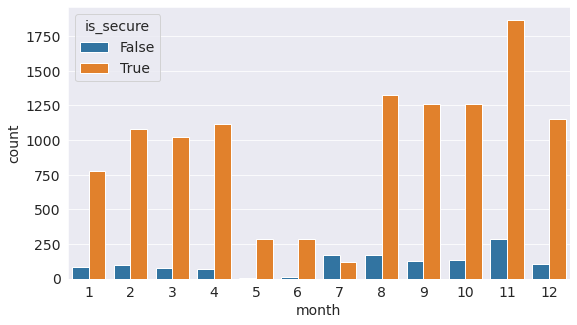

In [19]:
sns.countplot(x="month", hue="is_secure", data=df)

In [20]:
#View data for unprotected sites used taking a sample of 10
df[df["is_secure"] == False].sample(10)


,page_transition,title,url,time_usec,dt,date,hour,month,day_of_week,is_weekend,is_secure,domain,category
16932,TYPED,New Tab,chrome://newtab/,1597246067310609,2020-08-12 15:27:47.310609,2020-08-12,15,8,Wed,False,False,newtab,Other
287,LINK,JupyterLab,http://localhost:8888/lab,1625755413838546,2021-07-08 14:43:33.838546,2021-07-08,14,7,Thu,False,False,localhost,Learning
5598,TYPED,New Tab,chrome://newtab/,1612553730563111,2021-02-05 19:35:30.563111,2021-02-05,19,2,Fri,False,False,newtab,Other
15676,TYPED,New Tab,chrome://newtab/,1598528279490506,2020-08-27 11:37:59.490506,2020-08-27,11,8,Thu,False,False,newtab,Other
12587,TYPED,New Tab,chrome://newtab/,1603015807973225,2020-10-18 10:10:07.973225,2020-10-18,10,10,Sun,True,False,newtab,Other
6684,TYPED,New Tab,chrome://newtab/,1610540278786746,2021-01-13 12:17:58.786746,2021-01-13,12,1,Wed,False,False,newtab,Other
10649,TYPED,New Tab,chrome://newtab/,1605374888561121,2020-11-14 17:28:08.561121,2020-11-14,17,11,Sat,True,False,newtab,Other
12957,TYPED,New Tab,chrome://newtab/,1602338526772214,2020-10-10 14:02:06.772214,2020-10-10,14,10,Sat,True,False,newtab,Other
6471,TYPED,New Tab,chrome://newtab/,1610779353497901,2021-01-16 06:42:33.497901,2021-01-16,6,1,Sat,True,False,newtab,Other
10020,LINK,MainLogin,http://erp.tcetmumbai.in/MainNew.aspx?Usertype...,1605803775859637,2020-11-19 16:36:15.859637,2020-11-19,16,11,Thu,False,False,tcetmumbai,Other


Unprotected sites and their urls can be seen

In [21]:
#view site url names
df[df["is_secure"] == False].domain.unique()

array(['newtab', 'history', 'googlefiber', 'localhost',
       'fheoggkfdfchfphceeifdbepaooicaho', '000webhost', 'firebase',
       'tcetmumbai', 'rentacycle', 'digitaluniversity', 'myflixer',
       'brainkart', '127.0.0.1', 'cs50', 'adveric',
       'prepenseprepensedefiance', 'invitesuperstitiousadmire',
       'philosophicalregardlesssetback', 'about', 'speedtest',
       'speedtesttab'], dtype=object)

### Weekday vs Weekend browser usage:

<AxesSubplot:xlabel='hour', ylabel='count'>

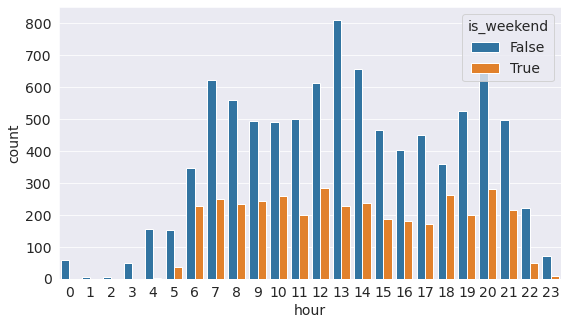

In [22]:
#is_weekend="Y" for saturday and sunday, "N" otherwise
sns.countplot(x="hour", hue="is_weekend", data=df)

As you can see i use my laptop more during the weekdays

This code can be filtered

<AxesSubplot:xlabel='date', ylabel='hour'>

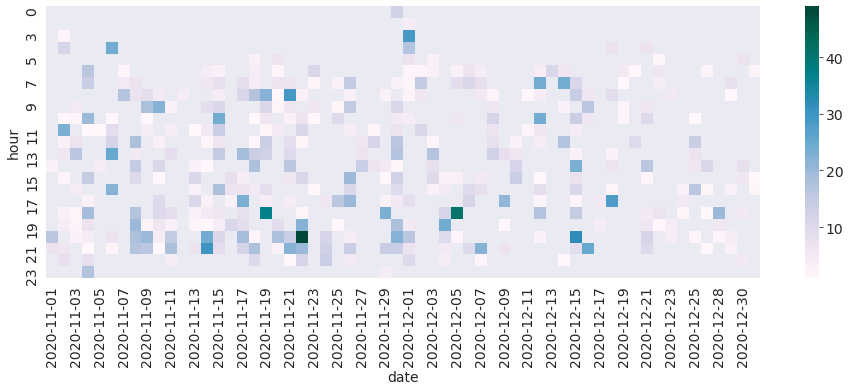

In [23]:
from matplotlib import pyplot as plt
# Getting unique values after grouping by hour and date
df_new = df[(df["month"] >= 11)].groupby(["hour", "date"])["domain"].size()
df_new = df_new.reset_index(name="count")
plt.figure(figsize = (16,5))
# Pivot the dataframe to create a [hour x date] matrix containing counts
sns.heatmap(df_new.pivot("hour", "date", "count"), annot=False, cmap="PuBuGn")

Nice heatmap!

<AxesSubplot:xlabel='date', ylabel='category'>

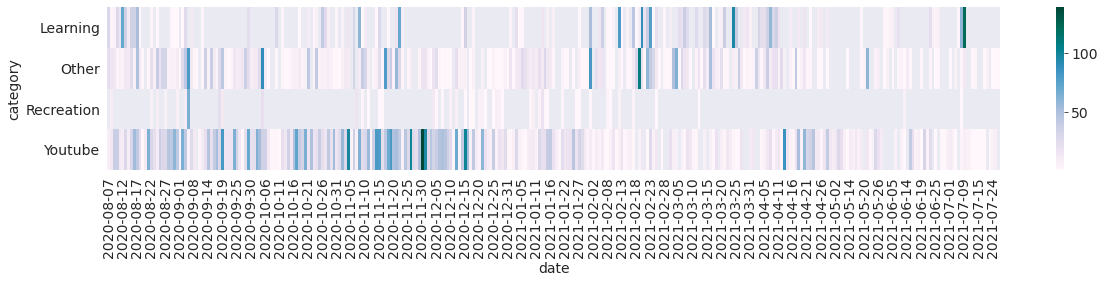

In [25]:
cat_arr = ["Learning", "Recreation", "Youtube", "Other"]
df_new = df[(df["category"].isin(cat_arr))].groupby([ "category","date"])["domain"].size()
df_new = df_new.reset_index(name="count")
plt.figure(figsize = (20,3))
# Pivot the dataframe to create a [hour x date] matrix containing counts
sns.heatmap(df_new.pivot( "category","date", "count"), annot=False, cmap="PuBuGn")

In [29]:
def get_cat_count(x):
    arr=[0,0,0,0]
    for i in list(x):
        if i == "Learning":
            arr[0]+=1
        elif i == "Recreation":
            arr[1]+=1
        elif  i== "Youtube":
            arr[2]+=1
        else:
            arr[3]+=1 
    return arr

Text(0.5, 1.0, 'no of times clicked on diff categories')

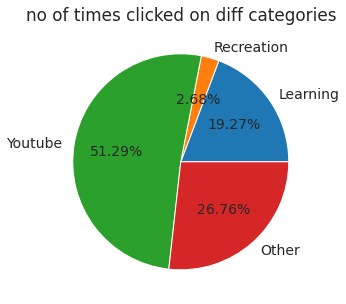

In [30]:
fig = plt.figure()

ax1 = fig.add_axes([0, 0, 0.75, 0.75], aspect=1) # add_axes([left, bottom, width, height],aspect=1)
# Viewers who react on videos
pie_vars = cat_arr;
pie_values =  get_cat_count(df["category"])
ax1.pie(pie_values,labels=pie_vars,autopct='%1.2f%%');
ax1.set_title('no of times clicked on diff ')

i spend a lot of time on youtube

<AxesSubplot:xlabel='day_of_week', ylabel='hour'>

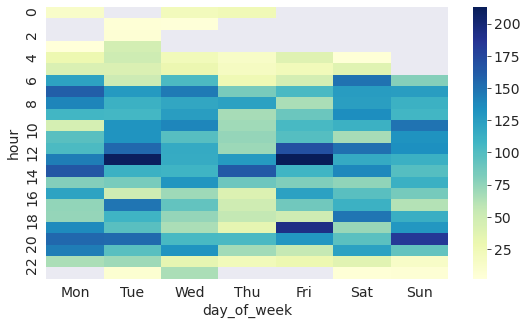

In [33]:
df_heat = df.groupby(["hour", "day_of_week"])["domain"].size().reset_index()
df_heat2 = df_heat.pivot("hour", "day_of_week", "domain")
sns.heatmap(df_heat2[days_arr] , cmap="YlGnBu")

Let us save and upload our work to Jovian before continuing

In [31]:
import jovian

In [32]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

## Asking and Answering Questions

Here are some random graphs and outputs



#### Q1:   Show heatmap of only a particular category(eg.youtube)

In [34]:
df_heat = df[df["category"] == "Youtube"].groupby(["hour", "day_of_week"])["category"].size().reset_index()

<AxesSubplot:xlabel='day_of_week', ylabel='hour'>

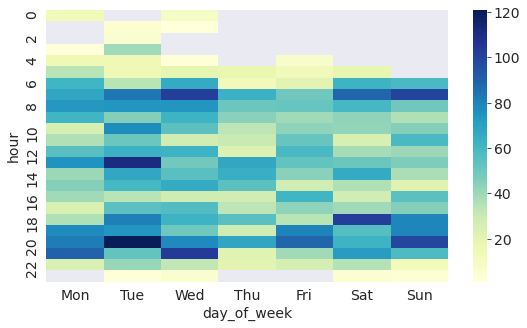

In [37]:
df_heat2 = df_heat.pivot("hour", "day_of_week", "category")
sns.heatmap(df_heat2[days_arr] , cmap="YlGnBu")

#### Q2: Some visited links on youtube

In [44]:
df_so = df[df["domain"] == "youtube"].groupby(["url", "title"]).size()
df_so = df_so.reset_index(name='count').sort_values('count',ascending=False)[["title", 'count']]
df_so.head(15)

,title,count
671,Subscriptions - YouTube,548
679,Trending - YouTube,308
398,YouTube,225
1213,valorant - YouTube,76
1184,trump - YouTube,76
1219,valorant protatomonster - YouTube,51
1174,toast - YouTube,49
668,Explore - YouTube,38
1209,valkyrae - YouTube,33
669,Library - YouTube,33


#### Q3: Show domains with most clicks

In [66]:
most_used = df.groupby(df['domain'],dropna=False)['domain'].count()
most_used = most_used.sort_values(ascending=False).head(15)

<AxesSubplot:xlabel='domain', ylabel='domain'>

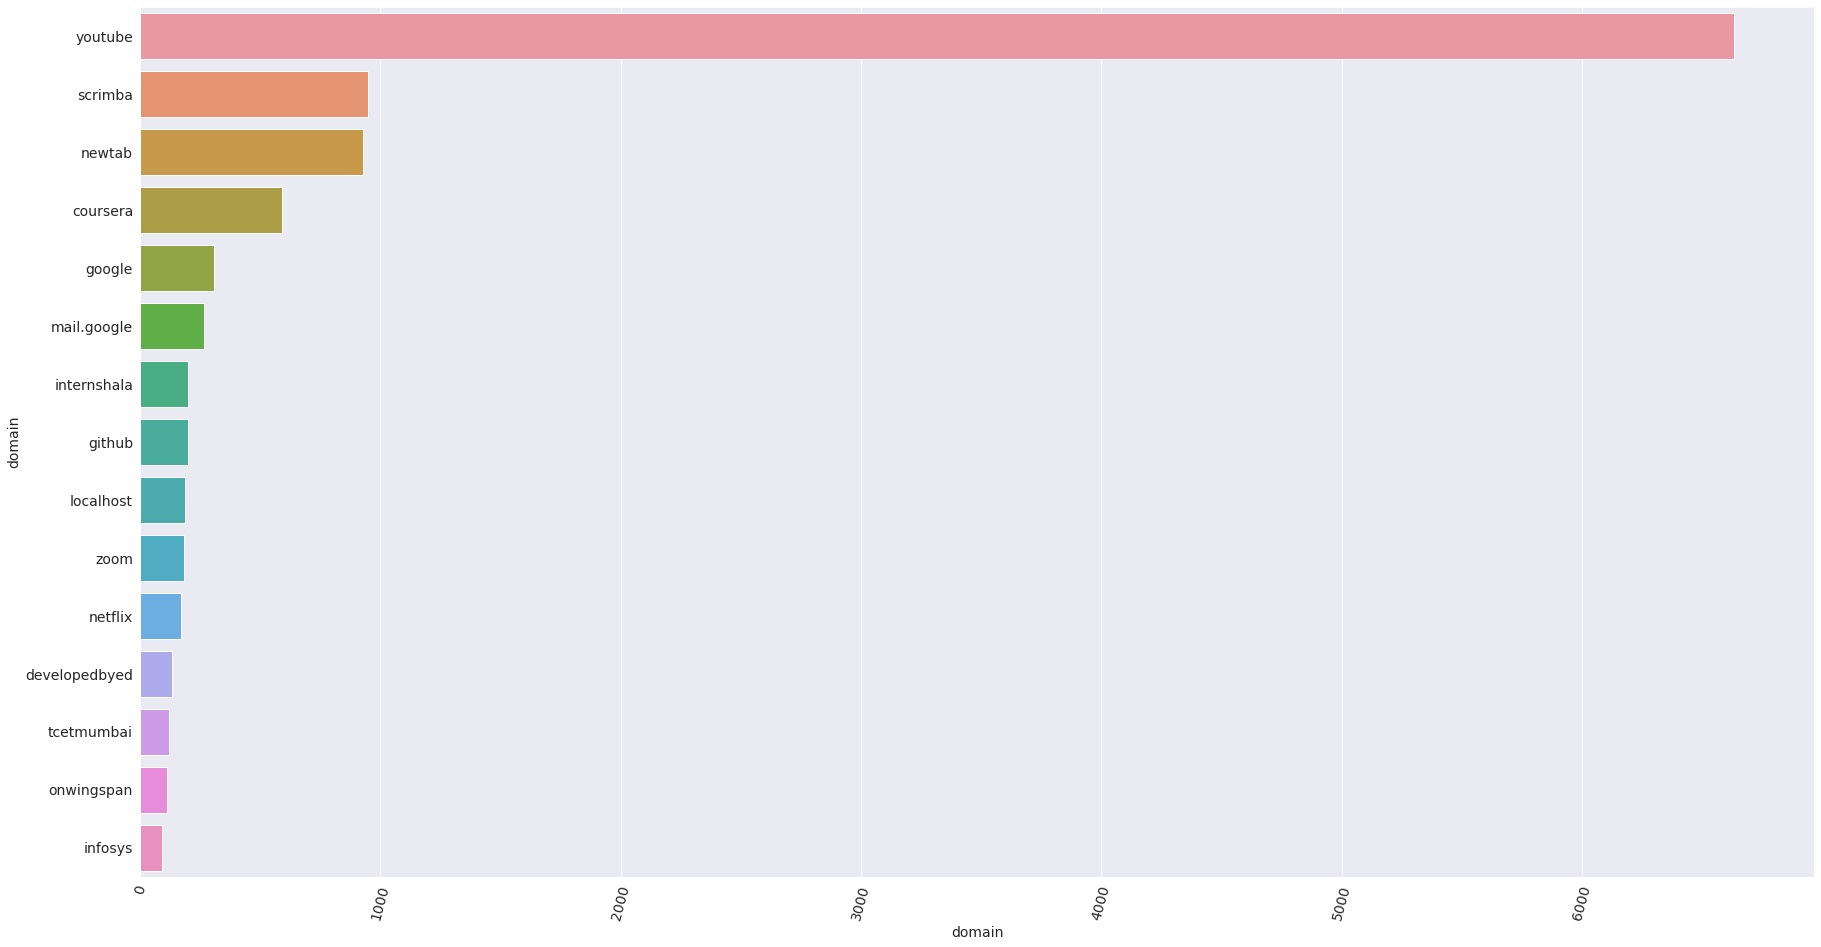

In [67]:
plt.figure(figsize=(30,16))
plt.xticks(rotation=75)
plt.ylabel('domain types');
plt.xlabel('times clicked');
sns.barplot(x=most_used, y=most_used.index)

#### Q4: Plot  amount  of links clicked related to learning

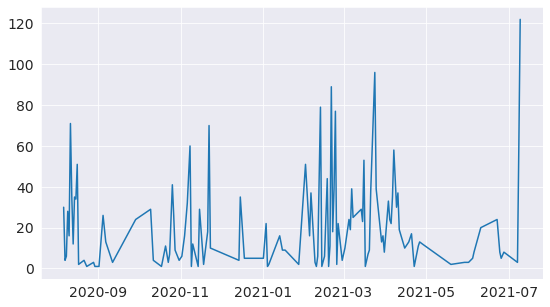

In [63]:
df_new = df[(df["category"].isin(["Learning"]))].groupby([ "date"])["domain"].size()
plt.plot(df_new)

#### Q5: Make a word cloud 

In [69]:
pip install wordcloud


     |████████████████████████████████| 363 kB 6.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [70]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [114]:
def as_text(x):
    value = ' '.join([str(element) for element in x])
    return str(value)    

In [120]:
text = as_text(df.domain.unique())


In [121]:
wordcloud = WordCloud().generate(text)

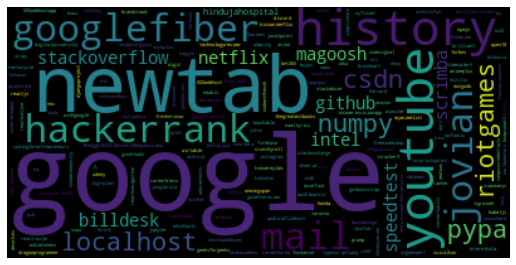

In [122]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us save and upload our work to Jovian before continuing.

In [123]:
import jovian

In [124]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

## Inferences and Conclusion

**TODO** - I am done with this course thank you very much

In [127]:
import jovian

In [128]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

## References and Future Work

Project inspired by freecodecamp guy

In [131]:
import jovian

In [132]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn


'https://jovian.ai/s1032180180/understanding-my-browsing-pattern-using-pandas-and-seaborn'

In [ ]:
jovian.submit(assignment="zero-to-pandas-project")

<IPython.core.display.Javascript object>